# **Import Library**

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score  
from sklearn.model_selection import train_test_split 

# **Data Preparation**

In [2]:
print(os.listdir('/kaggle/input'))

['garbage_classification']


## Rename Image File

In [3]:
# Define the base directory
base_dir = '/kaggle/input/garbage_classification/'
working_dir = '/kaggle/working/datasets1'

# Copy the dataset to the working directory 
if not os.path.exists(working_dir):
    shutil.copytree(base_dir, working_dir)

In [4]:
# Function to rename image files in each directory
def rename_images_in_directory(directory):
    for root, _, files in os.walk(directory):
        class_name = os.path.basename(root) 
        for idx, file in enumerate(files):
            if file.split('.')[-1].lower() in ['jpg', 'png']:
                new_filename = f"{class_name}_{idx}.jpg"  
                os.rename(os.path.join(root, file), os.path.join(root, new_filename)) 

In [5]:
# Rename images in each directory
rename_images_in_directory(working_dir)

In [6]:
import os
import zipfile

def zip_folder(folder_path, output_path):
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

# Define the folder to be zipped and the output zip file
folder_to_zip = '/kaggle/working/datasets1'
output_zip_file = '/kaggle/working/datasets1.zip'

# Zip the folder
zip_folder(folder_to_zip, output_zip_file)
print(f'Folder {folder_to_zip} has been zipped as {output_zip_file}')


Folder /kaggle/working/datasets1 has been zipped as /kaggle/working/datasets1.zip


## Gather Images Path and Label also Create Dataframe

In [7]:
# Function to gather image paths and labels
def gather_data(base_dir, sub_dir):
    image_paths = []  # Inisialisasi list untuk menyimpan path gambar
    labels = []  # Inisialisasi list untuk menyimpan label
    dir_path = os.path.join(base_dir, sub_dir)
    
    for root, _, files in os.walk(dir_path):  # `_` digunakan karena `dirs` tidak dipakai
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):  # Asumsi format gambar
                image_path = os.path.join(root, file)
                # Ekstrak label dari struktur direktori (nama folder terakhir)
                label = os.path.basename(root)  # Nama folder menjadi label
                image_paths.append(image_path)
                labels.append(label)
    
    return image_paths, labels

In [8]:
# Gather data for the dataset
image_paths, image_labels = gather_data(working_dir, '')

# Create DataFrame for the dataset
df = pd.DataFrame({'image_path': image_paths, 'label': image_labels})

# Tampilkan DataFrame untuk memastikan hasil
print(df.head())


                                          image_path        label
0  /kaggle/working/datasets1/white-glass/white-gl...  white-glass
1  /kaggle/working/datasets1/white-glass/white-gl...  white-glass
2  /kaggle/working/datasets1/white-glass/white-gl...  white-glass
3  /kaggle/working/datasets1/white-glass/white-gl...  white-glass
4  /kaggle/working/datasets1/white-glass/white-gl...  white-glass


## Split Dataset

In [9]:
# Adjustable code area: Variations in Dataset Division
# -----------------------------------------------------
# Modify the train-test-validation split ratios here
# First split: 75% train : 25% (validation + test)

train_df, validation_test_df = train_test_split(
    df, test_size=0.25, stratify=df['label'], random_state=42
)

# Second split: 60% validation, 40% test from the 25% validation_test_df
validation_df, test_df = train_test_split(
    validation_test_df, test_size=0.4, stratify=validation_test_df['label'], random_state=42
)

# Display dataset sizes
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(validation_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 11636
Validation set size: 2327
Test set size: 1552


## Save Dataframe to CSV

In [10]:
# Save DataFrames to CSV files
train_df.to_csv('train_dataset.csv', index=False)
validation_df.to_csv('validation_dataset.csv', index=False)
test_df.to_csv('test_dataset.csv', index=False)

print("DataFrames have been saved as CSV files:")
print("- train_dataset.csv")
print("- validation_dataset.csv")
print("- test_dataset.csv")


DataFrames have been saved as CSV files:
- train_dataset.csv
- validation_dataset.csv
- test_dataset.csv


In [11]:
# Function to check the distribution of labels in each subset
def check_distribution(df, subset_name):
    print(f'Distribution in {subset_name} set:')
    distribution = df['label'].value_counts()  # Menghitung jumlah kemunculan tiap label
    print(distribution)
    print("\n")

# Check distribution in each subset
check_distribution(train_df, 'Train')
check_distribution(validation_df, 'Validation')
check_distribution(test_df, 'Test')

# Tampilkan jumlah data di setiap subset
print(f"Number of samples in Train set: {len(train_df)}")
print(f"Number of samples in Validation set: {len(validation_df)}")
print(f"Number of samples in Test set: {len(test_df)}")


Distribution in Train set:
label
clothes        3993
shoes          1483
paper           787
biological      739
battery         709
cardboard       668
plastic         649
white-glass     581
metal           577
trash           523
green-glass     472
brown-glass     455
Name: count, dtype: int64


Distribution in Validation set:
label
clothes        799
shoes          296
paper          158
biological     148
battery        142
cardboard      134
plastic        130
white-glass    116
metal          115
trash          104
green-glass     94
brown-glass     91
Name: count, dtype: int64


Distribution in Test set:
label
clothes        533
shoes          198
paper          105
biological      98
battery         94
cardboard       89
plastic         86
white-glass     78
metal           77
trash           70
green-glass     63
brown-glass     61
Name: count, dtype: int64


Number of samples in Train set: 11636
Number of samples in Validation set: 2327
Number of samples in Test set: 1552


In [12]:
df = pd.read_csv('train_dataset.csv')
df.head()

,image_path,label
0,/kaggle/working/datasets1/biological/biologica...,biological
1,/kaggle/working/datasets1/white-glass/white-gl...,white-glass
2,/kaggle/working/datasets1/green-glass/green-gl...,green-glass
3,/kaggle/working/datasets1/clothes/clothes_3983...,clothes
4,/kaggle/working/datasets1/clothes/clothes_4726...,clothes


# **Data preprocessing**

## One-hot Encoding on Labels (Multilabel Classification)

In [13]:
# Load the CSV files
train_df = pd.read_csv('train_dataset.csv')
validation_df = pd.read_csv('validation_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

# Initialize MultiLabelBinarizer for one-hot encoding the labels
mlb = MultiLabelBinarizer()

# Split labels into list
train_df['label'] = train_df['label'].apply(lambda x: x.split(' ')) 
validation_df['label'] = validation_df['label'].apply(lambda x: x.split(' '))
test_df['label'] = test_df['label'].apply(lambda x: x.split(' '))

# Fit the binarizer and transform the labels
train_labels = mlb.fit_transform(train_df['label'])
validation_labels = mlb.transform(validation_df['label'])
test_labels = mlb.transform(test_df['label'])

# Add encoded labels as separate columns
train_df = pd.concat([train_df, pd.DataFrame(train_labels, columns=mlb.classes_)], axis=1)
validation_df = pd.concat([validation_df, pd.DataFrame(validation_labels, columns=mlb.classes_)], axis=1)
test_df = pd.concat([test_df, pd.DataFrame(test_labels, columns=mlb.classes_)], axis=1)

#Save the class label
class_labels = mlb.classes_

In [14]:
print(train_df.head())

                                          image_path          label  battery  \
0  /kaggle/working/datasets1/biological/biologica...   [biological]        0   
1  /kaggle/working/datasets1/white-glass/white-gl...  [white-glass]        0   
2  /kaggle/working/datasets1/green-glass/green-gl...  [green-glass]        0   
3  /kaggle/working/datasets1/clothes/clothes_3983...      [clothes]        0   
4  /kaggle/working/datasets1/clothes/clothes_4726...      [clothes]        0   

   biological  brown-glass  cardboard  clothes  green-glass  metal  paper  \
0           1            0          0        0            0      0      0   
1           0            0          0        0            0      0      0   
2           0            0          0        0            1      0      0   
3           0            0          0        1            0      0      0   
4           0            0          0        1            0      0      0   

   plastic  shoes  trash  white-glass  
0        0      

## Image Augmentations

In [15]:
# Adjustable code area: Data Augmentation Technique
#--------------------------------------------------
# can modify the datagen parameters here to experiment with different augmentations 
# Prepare the image data generators
# datagen = ImageDataGenerator(rescale=1./255)

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Optional: built-in validation split
#   rescale=1./255,
#   rotation_range=40,
#   width_shift_range=0.2,  
#   height_shift_range=0.2,  
#   shear_range=0.2,
)

## Create Data Generators For Train, Validation, and Test Set

In [16]:
# Function to create a data generator
def create_generator(dataframe, datagen):
    return datagen.flow_from_dataframe(
        dataframe,
        x_col='image_path',  # Nama kolom dengan path gambar
        y_col=class_labels.tolist(),  # Nama kolom dengan label (pastikan sesuai dengan DataFrame)
        target_size=(299, 299),  # Ukuran gambar yang diubah
        batch_size=32,  # Ukuran batch
        class_mode='raw'  # Untuk masalah regresi atau raw labels
    )

# Creating generators for train, validation, and test sets
train_generator = create_generator(train_df, datagen)
validation_generator = create_generator(validation_df, datagen)
test_generator = create_generator(test_df, datagen)

Found 11636 validated image filenames.
Found 2327 validated image filenames.
Found 1552 validated image filenames.


# **Model Development**

## Define Base Model Architecture (Inception V3 = Transfer Learning)

In [17]:
base_model = InceptionV3(weights='imagenet', include_top=False)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Add Costum Layer For Multilabel Classification

In [18]:
# Get the output from the base model
from tensorflow.keras.regularizers import l2

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1824, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)  # Increase dropout rate
predictions = Dense(len(class_labels), activation='sigmoid', 
                    kernel_regularizer=l2(0.001))(x)
# Another to try on:
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1824, activation='relu')(x)
# x = Dropout(0.2)(x)  # Add dropout layer
# predictions = Dense(len(class_labels), activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

## Compile Model

In [19]:
from tensorflow.keras.optimizers import Adam

# Compile the model
optimizer = Adam(learning_rate=0.001)  
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# After initial training, unfreeze some top layers of base model
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile with very low learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

## Callbacks

In [20]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    mode='min'
)

In [21]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # More aggressive reduction
    patience=3,
    min_lr=1e-5,
    verbose=1
)

## Train Model With Train and Validation Set

In [22]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732596849.432965      69 service.cc:145] XLA service 0x7c6218002010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732596849.433030      69 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732596849.433035      69 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/364 ━━━━━━━━━━━━━━━━━━━━ 3:27:13 34s/step - accuracy: 0.0312 - loss: 2.6857

I0000 00:00:1732596868.410664      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


364/364 ━━━━━━━━━━━━━━━━━━━━ 319s 786ms/step - accuracy: 0.4857 - loss: 2.2236 - val_accuracy: 0.8780 - val_loss: 1.8836 - learning_rate: 1.0000e-05
Epoch 2/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 262s 710ms/step - accuracy: 0.8596 - loss: 1.8341 - val_accuracy: 0.9162 - val_loss: 1.6615 - learning_rate: 1.0000e-05
Epoch 3/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 259s 700ms/step - accuracy: 0.9004 - loss: 1.6181 - val_accuracy: 0.9330 - val_loss: 1.4630 - learning_rate: 1.0000e-05
Epoch 4/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 259s 700ms/step - accuracy: 0.9250 - loss: 1.4236 - val_accuracy: 0.9416 - val_loss: 1.2825 - learning_rate: 1.0000e-05
Epoch 5/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 260s 703ms/step - accuracy: 0.9338 - loss: 1.2454 - val_accuracy: 0.9514 - val_loss: 1.1166 - learning_rate: 1.0000e-05
Epoch 6/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 260s 702ms/step - accuracy: 0.9449 - loss: 1.0812 - val_accuracy: 0.9544 - val_loss: 0.9651 - learning_rate: 1.0000e-05
Epoch 7/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 258s 699ms/

## Plot Training

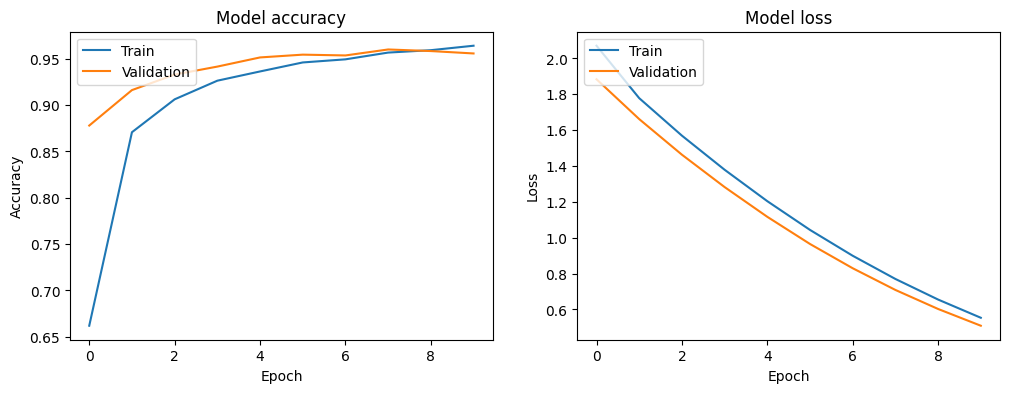

In [23]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Save Model

In [24]:
# Save the trained model
model.save('model_capstonelancar.h5')


#Test Datah

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


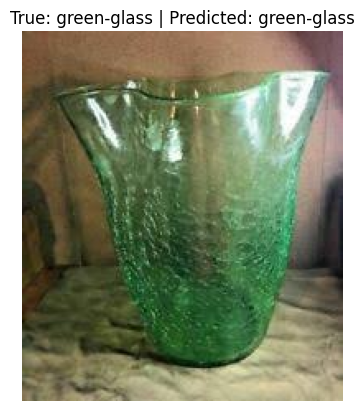

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


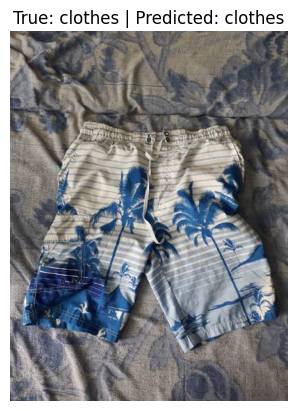

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


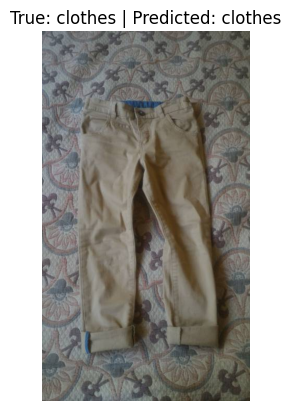

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


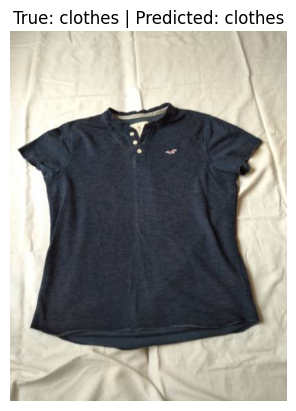

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


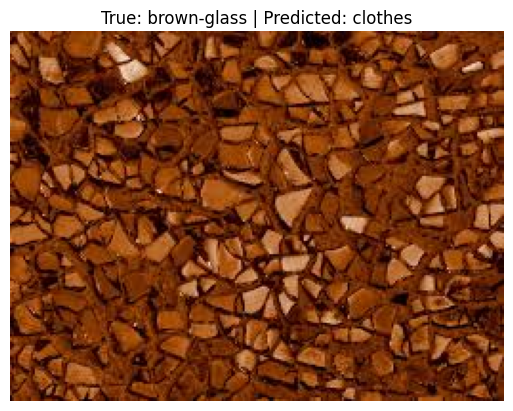

In [25]:
import os
import random
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd

# Load model yang telah dilatih
model_path = 'model_capstonelancar.h5'  # Path ke model yang disimpan
model = load_model(model_path)

# Class labels
class_labels = [
    'battery', 'biological', 'brown-glass', 'cardboard', 'clothes',
    'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass'
]

# Load dataset DataFrame
test_df_path = 'test_dataset.csv'  # Path ke CSV file dataset test
test_df = pd.read_csv(test_df_path)

# Fungsi untuk memuat dan memproses gambar
def preprocess_image(image, target_size=(299, 299)):
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalisasi
    image = np.expand_dims(image, axis=0)  # Tambahkan dimensi batch
    return image

# Fungsi untuk mengetes gambar secara acak dari dataset
def test_random_sample(test_df, num_samples=5):
    # Pilih sampel acak dari dataset test
    samples = test_df.sample(n=num_samples)
    
    for index, row in samples.iterrows():
        img_path = row['image_path']
        true_label = row['label']
        
        # Baca gambar
        img = cv2.imread(img_path)
        if img is None:
            print(f"Gambar tidak ditemukan: {img_path}")
            continue
        
        # Preprocess gambar
        processed_img = preprocess_image(img)
        
        # Prediksi dengan model
        predictions = model.predict(processed_img)[0]
        predicted_class = class_labels[np.argmax(predictions)]
        
        # Tampilkan hasil
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"True: {true_label} | Predicted: {predicted_class}")
        plt.axis("off")
        plt.show()

# Uji dengan memilih gambar acak dari dataset test
test_random_sample(test_df, num_samples=5)